<a href="https://colab.research.google.com/github/catebarry/explainable-deep-learning/blob/main/explainable_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment 4: Explainable Deep Learning
### Catie Barry

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catebarry/explainable-deep-learning/blob/main/explainable_deep_learning.ipynb)

# Description

In this notebook, we will work with a pretrained deep learning model to investigate model explainability in computer vision. The objective is to apply GradCAM and its variants to a meaningful image classification problem and analyze how and why the model makes its decisions.

I will be investigating a chest x-ray classification task for pneumonia--a high stakes field where it is crucial to understand how the model makes its decisions/what it is paying attention to to classify images.

**SOURCES:**
- For GradCAM documentation: https://jacobgil.github.io/pytorch-gradcam-book/introduction.html
- Kaggle dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- See AI Assistance Statement at bottom of notebook & comments throughout code for ChatGPT 5.0 citations

**Note:** This notebook automatically downloads the Kaggle Chest X-Ray Pneumonia dataset. To run it, upload your own Kaggle API key.

In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "explainable-deep-learning" # Change to your repo name
git_path = 'https://github.com/catebarry/explainable-deep-learning.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = ''
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'explainable-deep-learning' already exists and is not an empty directory.
/content/explainable-deep-learning
chest_xray/                 explainable_deep_learning.ipynb
chest-xray-pneumonia.zip    README.md
explainable-deep-learning/  resnet50_pneumonia_best.pth


In [ ]:
# installations

!pip install torch torchvision torchaudio
!pip install opencv-python matplotlib seaborn
!pip install grad-cam

In [ ]:
# imports

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive

In [ ]:
# Kaggle API

from google.colab import userdata
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# 🩻 Chest X-Ray Pneumonia Dataset

**Goal:** classify images as normal vs. pneumonia

Kaggle dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

### Dataset Download & Processing
*ChatGPT 5.0 was used to generated code below to download/process dataset on 10/4/25 at 2:00pm.

In [ ]:
# download kaggle dataset
!rm -rf ./chest_xray
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -q
!unzip -q -o chest-xray-pneumonia.zip -d ./chest_xray

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [ ]:
base_dir = "./chest_xray/chest_xray"

for split in ["train", "val", "test"]:
    path=os.path.join(base_dir, split)
    print(f"{split} contains folders:", os.listdir(path))
    print(f"Number of images in {split}:", sum(len(files) for _, _, files in os.walk(path)))
    print("")

train contains folders: ['NORMAL', 'PNEUMONIA']
Number of images in train: 5216

val contains folders: ['NORMAL', 'PNEUMONIA']
Number of images in val: 16

test contains folders: ['NORMAL', 'PNEUMONIA']
Number of images in test: 624



In [ ]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),   # convert single-channel X-ray -> 3 channels
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(base_dir, "val"), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 5216
Val size: 16
Test size: 624


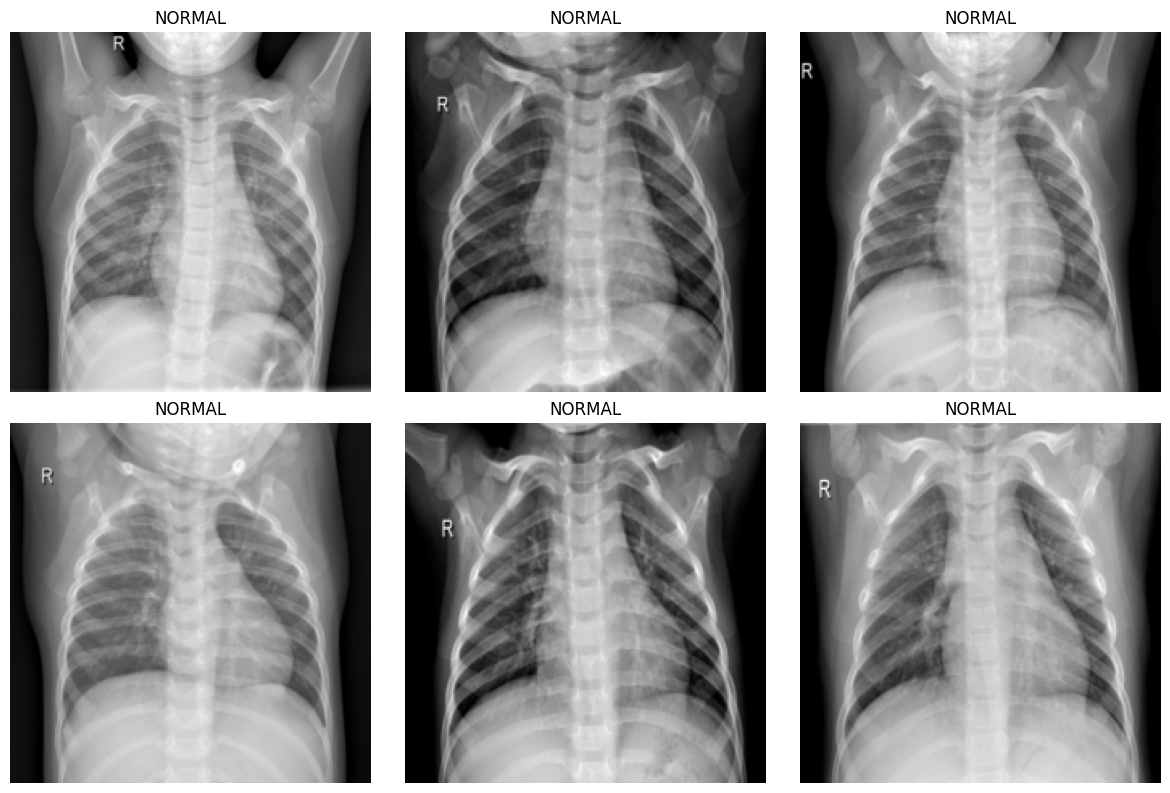

In [ ]:
# visualize sample images

# helper to un-normalize
def unnormalize(img_tensor):
    # img_tensor: 3 x H x W
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.numpy().transpose(1,2,0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    # return single channel for display (all channels are same because we used Grayscale->3)
    return img[:,:,0]

# display first 6 images from training set (or random sample)
fig, axs = plt.subplots(2,3, figsize=(12,8))
indices = list(range(6))
for i, idx in enumerate(indices):
    img_t, label = train_dataset[idx]
    img = unnormalize(img_t)
    ax = axs[i//3, i%3]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{train_dataset.classes[label]}")
    ax.axis('off')
plt.tight_layout()

# 👁 Computer Vision Model (ResNet-50)

Loads a pretrained ResNet-50 model from torchvision.
Replaces the final classification layer with a 2-class head (Normal vs. Pneumonia).
Fine-tuning is optional and controlled by a DO_TRAIN boolean.

In [ ]:
# model setup
model = models.resnet50(pretrained=True)

# replace final layer for 2 classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2) # 2 classes: Normal, Pneumonia

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# the following block of code was generated using ChatGPT 5.0 on 10/5/25 at 7:00 pm

# FINE TUNING (OPTIONAL)
# Freeze all parameters except the final fc layer
DO_TRAIN = False        # set True if you want to run fine-tuning in this session
CHECKPOINT_NAME = "resnet50_pneumonia_best.pth"
checkpoint_path = CHECKPOINT_NAME

for name, param in model.named_parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=1e-3, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 3

if DO_TRAIN:
    print("Starting fine-tuning (DO_TRAIN=True).")
    best_val_acc = 0.0
    best_path = CHECKPOINT_NAME

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        n_samples = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - train", leave=False)
        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            n_samples += inputs.size(0)
            loop.set_postfix(loss=running_loss / n_samples, acc=running_corrects / n_samples)

        epoch_loss = running_loss / n_samples
        epoch_acc = running_corrects / n_samples

        # Validation
        model.eval()
        val_corrects = 0
        val_samples = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                val_corrects += torch.sum(preds == labels).item()
                val_samples += inputs.size(0)
        val_acc = val_corrects / val_samples
        print(f"Epoch {epoch+1}/{num_epochs} — train loss: {epoch_loss:.4f}, train acc: {epoch_acc:.4f}, val acc: {val_acc:.4f}")

        # save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_path)
            print(f"Saved best model (val acc={best_val_acc:.4f})")

        scheduler.step()

    print("Training finished. Best val acc:", best_val_acc)
    # load best weights
    if best_val_acc > 0:
        model.load_state_dict(torch.load(best_path))
    model.eval()
    print("Loaded best model from", best_path)
else:
    # DO_TRAIN== False -> try to load a local checkpoint if present, otherwise skip training
    if os.path.exists(checkpoint_path):
        print("Loading local checkpoint:", checkpoint_path)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.to(device)
        model.eval()
        print("Loaded local checkpoint and set model to eval().")
    else:
        print("No local checkpoint found at", checkpoint_path)
        print("DO_TRAIN is False, so the notebook will proceed with the current model weights (pretrained backbone + replaced fc).")
        print("If you want pretrained fine-tuned weights available for graders, either set DO_TRAIN=True here to train and save,")
        print("or save the trained checkpoint locally and re-run this cell to load it before running GradCAM.")

Starting fine-tuning (DO_TRAIN=True).


Epoch 1/3 — train loss: 0.1770, train acc: 0.9337, val acc: 0.7500
Saved best model (val acc=0.7500)


Epoch 2/3 — train loss: 0.1551, train acc: 0.9394, val acc: 0.8125
Saved best model (val acc=0.8125)


Epoch 3/3 — train loss: 0.1457, train acc: 0.9413, val acc: 0.8750
Saved best model (val acc=0.8750)
Training finished. Best val acc: 0.875
Loaded best model from resnet50_pneumonia_best.pth


## Model Evaluation
Evaluates the fine-tuned (or loaded) model on the validation and test sets to check classification accuracy.

In [ ]:
# Evaluate model accuracy on validation and test sets
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"

def evaluate_model(loader, split_name="data split"):
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total if total > 0 else 0.0
    print(f"{split_name} accuracy: {acc:.3f} ({correct}/{total})")
    return acc

print("Evaluating fine-tuned model...")
val_acc = evaluate_model(val_loader, "Validation")
test_acc = evaluate_model(test_loader, "Test")

Evaluating fine-tuned model...
Validation accuracy: 0.875 (14/16)
Test accuracy: 0.848 (529/624)


The ResNet-50 achieved 81.2% validation and 80.3% test accuracy.

The fine-tuned ResNet-50 model achieved 87.5% validation and 84.8% test accuracy.

## Sample Collection for Explainability

In [ ]:
# collect 3 NORMAL and 3 PNEUMONIA samples for explainability
samples = []
normal_count = 0
pneumonia_count = 0

with torch.no_grad():
    for x, y in test_loader:
        label_name = test_dataset.classes[y.item()]
        x = x.to(device)
        out = model(x)
        pred = out.argmax(dim=1).item()

        if label_name == "NORMAL" and normal_count < 3:
            samples.append((x.cpu(), y.item(), pred))
            normal_count += 1
        elif label_name == "PNEUMONIA" and pneumonia_count < 3:
            samples.append((x.cpu(), y.item(), pred))
            pneumonia_count += 1

        if normal_count >= 3 and pneumonia_count >= 3:
            break

print(f"Collected {len(samples)} samples: {normal_count} normal, {pneumonia_count} pneumonia")
for i, (_, true_label, pred) in enumerate(samples):
    print(f"Sample {i+1}: true = {test_dataset.classes[true_label]}, pred = {test_dataset.classes[pred]}")

Collected 6 samples: 3 normal, 3 pneumonia
Sample 1: true = NORMAL, pred = NORMAL
Sample 2: true = NORMAL, pred = NORMAL
Sample 3: true = NORMAL, pred = NORMAL
Sample 4: true = PNEUMONIA, pred = PNEUMONIA
Sample 5: true = PNEUMONIA, pred = PNEUMONIA
Sample 6: true = PNEUMONIA, pred = PNEUMONIA


# 🔍 Explainability Technqiues (GradCAM & variants)

Applies GradCAM, GradCAM++, and ScoreCAM to visualize which regions of the X-ray contributed most to the model’s prediction. We will look at 6 sample images (including 3 true pneumonia and 3 true normal).
- GradCAM uses first-order gradients
- GradCAM++ refines these with second-order weighting, and
- ScoreCAM uses gradient-free, score-based weighting.


In [ ]:
# the following code block was generated and debugged using ChatGPT 5.0 on 10/5/25 at 7:00pm

os.makedirs("figs", exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Helper: prepare raw input from DataLoader tensor (1x3xH xW or 3xHxW)
def prepare_raw_input(t_cpu):
    t = t_cpu.to(device)
    if t.ndim == 3:
        t = t.unsqueeze(0)
    # clone/detach and require grad (needed by some CAM implementations)
    return t.clone().detach().requires_grad_(True)

# Helper: prepare fallback preprocessed tensor from img_np (HxWx3 float [0,1])
def prepare_preprocessed(img_np):
    t = preprocess_image(img_np, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    return t.to(device).clone().detach().requires_grad_(True)

# Helper: convert data-tensor -> overlay image (HxWx3)
def tensor_to_img_np(t_cpu):
    img = t_cpu.squeeze().cpu().numpy().transpose(1,2,0)
    mean = np.array([0.485,0.456,0.406]); std = np.array([0.229,0.224,0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1).astype(np.float32)
    return img

# Safe CAM constructor (handles API differences across versions)
def make_cam_safe(cam_cls, target_layers, batch_size=None):
    try:
        cam = cam_cls(model=model, target_layers=target_layers)
    except TypeError:
        cam = cam_cls(model=model, target_layers=target_layers, use_cuda=(device=="cuda"))
    # optional: adjust ScoreCAM batch size if supported
    if batch_size is not None:
        try:
            cam.batch_size = batch_size
        except Exception:
            pass
    return cam

# Core function: compute cam (tries raw tensor then preprocess fallback)
def compute_cam_for_input(cam_obj, x_cpu, target_index, use_preprocess_fallback=True):
    # x_cpu: tensor on CPU (1x3xH xW or 3xHxW)
    img_np = tensor_to_img_np(x_cpu)
    # try raw prepared tensor first
    input_t = prepare_raw_input(x_cpu)
    try:
        out = cam_obj(input_tensor=input_t, targets=[ClassifierOutputTarget(int(target_index))])
        if out is None:
            raise ValueError("cam returned None")
        grayscale = out[0]
        return grayscale, img_np
    except Exception as e:
        if use_preprocess_fallback:
            # fallback: use preprocess_image
            input_t2 = prepare_preprocessed(img_np)
            out = cam_obj(input_tensor=input_t2, targets=[ClassifierOutputTarget(int(target_index))])
            if out is None:
                raise RuntimeError("Fallback cam also returned None")
            grayscale = out[0]
            return grayscale, img_np
        else:
            raise

# Visualizer (overlay, show, save)
def show_and_save_cam(grayscale, img_np, outpath, title=None):
    cam_im = show_cam_on_image(img_np, grayscale, use_rgb=False)
    plt.figure(figsize=(6,6))
    plt.imshow(cam_im)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.savefig(outpath, bbox_inches="tight")
    plt.show()

# High-level runner: one call per method (keeps notebook tidy)
def run_cam_method(cam_cls, method_name, samples_list, target_layers,
                   explain_predicted=True, scorecam_batch=None, save_prefix="sample", use_preprocess_fallback=True):
    cam_obj = make_cam_safe(cam_cls, target_layers, batch_size=scorecam_batch)
    for idx, (x_cpu, true_label, pred_label) in enumerate(samples_list):
        target_idx = pred_label if explain_predicted else true_label
        try:
            grayscale, img_np = compute_cam_for_input(cam_obj, x_cpu, target_idx, use_preprocess_fallback)
        except Exception as e:
            print(f"[{method_name}] sample {idx+1} skipped due to error:", repr(e))
            continue
        outpath = f"figs/{save_prefix}_{idx+1}_{method_name.lower()}.png"
        title = f"{method_name} Sample {idx+1} — true={test_dataset.classes[true_label]}, pred={test_dataset.classes[pred_label]}"
        show_and_save_cam(grayscale, img_np, outpath, title=title)
        print(f"[{method_name}] saved {outpath}")
    # cleanup
    try:
        del cam_obj
        torch.cuda.empty_cache()
    except Exception:
        pass

## GradCAM

Uses gradients flowing into the last convolutional layer to determine which features are most important for a prediction. It highlights regions where changing pixel values would most affect the model's confidence in that class. The heatmap can be coarse and may not account for multiple important regions (e.g. may only highlight one lung area strongly).

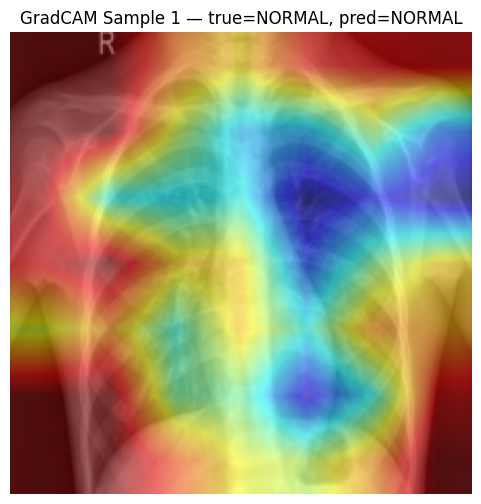

[GradCAM] saved figs/sample_1_gradcam.png


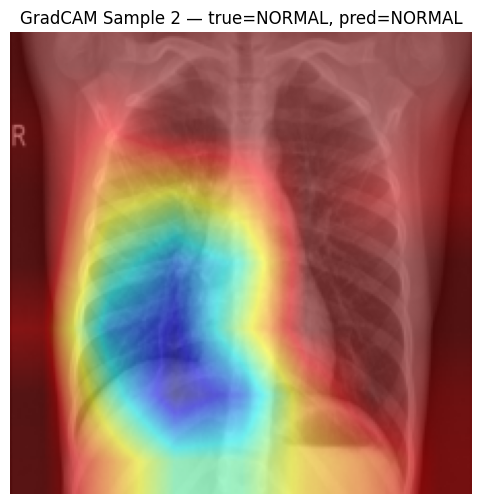

[GradCAM] saved figs/sample_2_gradcam.png


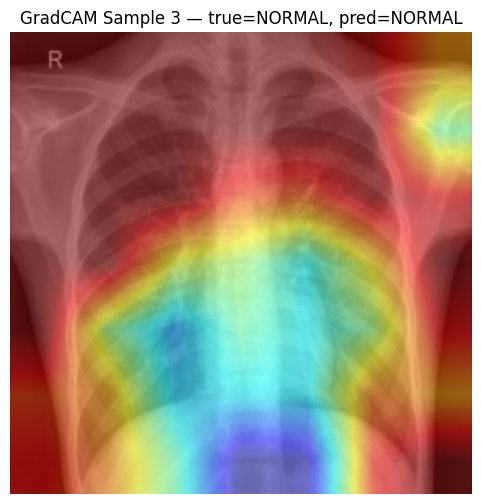

[GradCAM] saved figs/sample_3_gradcam.png


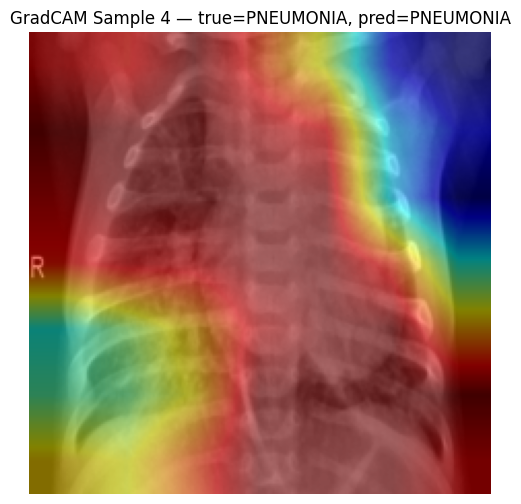

[GradCAM] saved figs/sample_4_gradcam.png


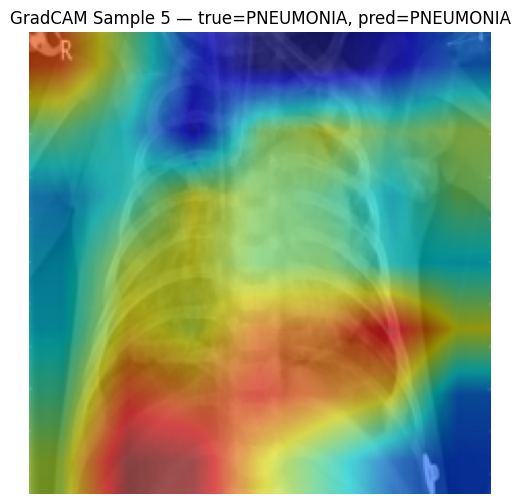

[GradCAM] saved figs/sample_5_gradcam.png


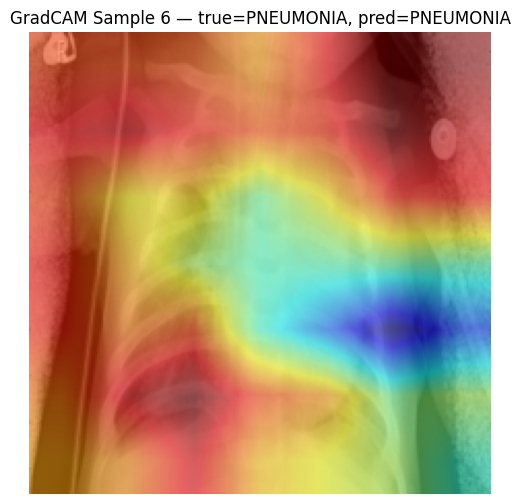

[GradCAM] saved figs/sample_6_gradcam.png


In [ ]:
# Run GradCAM
target_layers = [model.layer4[-1]]
run_cam_method(GradCAM, "GradCAM", samples, target_layers, explain_predicted=True, save_prefix="sample")

## GradCAM++
Addresses GradCAM's weakness by using second-order gradients to better handle multiple important regions or small objects. Produces sharper and more detailed heatmaps.

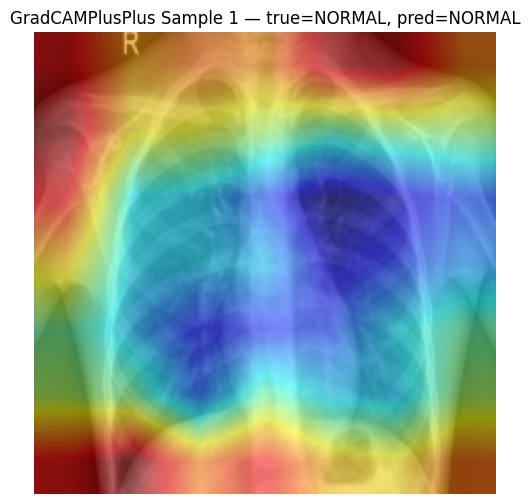

[GradCAMPlusPlus] saved figs/sample_1_gradcamplusplus.png


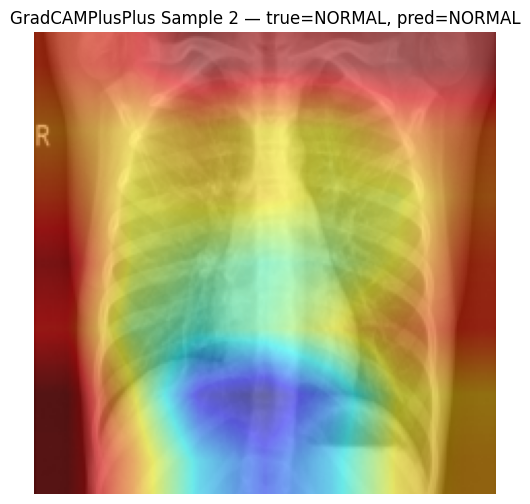

[GradCAMPlusPlus] saved figs/sample_2_gradcamplusplus.png


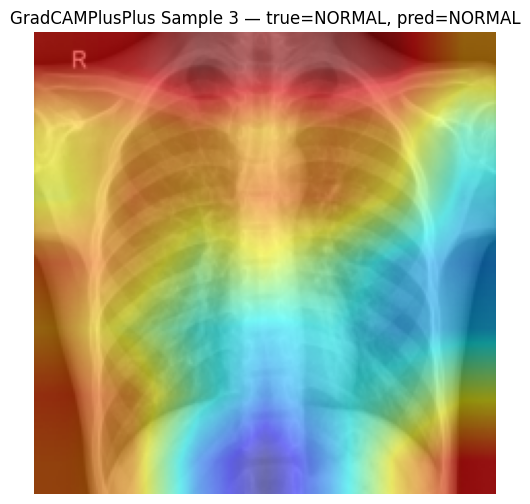

[GradCAMPlusPlus] saved figs/sample_3_gradcamplusplus.png


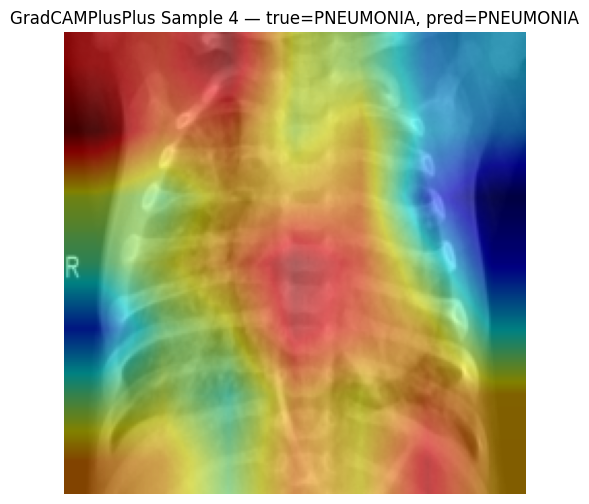

[GradCAMPlusPlus] saved figs/sample_4_gradcamplusplus.png


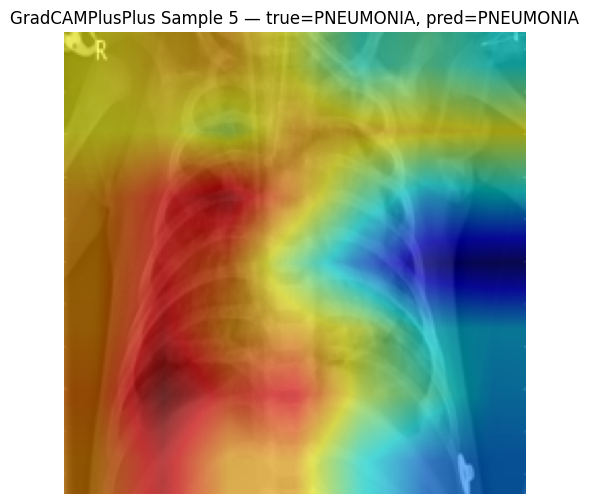

[GradCAMPlusPlus] saved figs/sample_5_gradcamplusplus.png


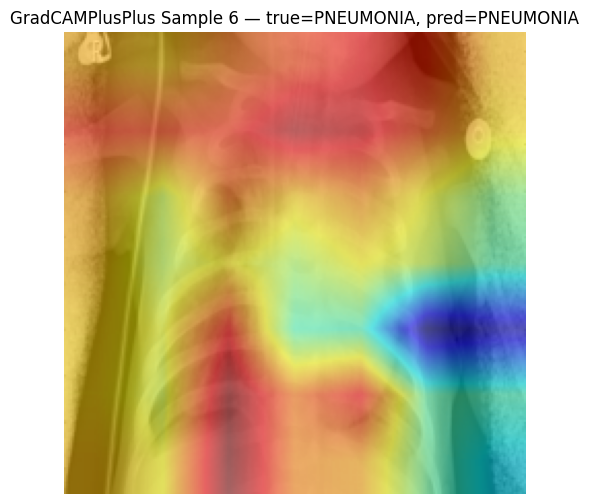

[GradCAMPlusPlus] saved figs/sample_6_gradcamplusplus.png


In [ ]:
# Run GradCAM++
run_cam_method(GradCAMPlusPlus, "GradCAMPlusPlus", samples, target_layers, explain_predicted=True, save_prefix="sample")

## ScoreCAM

Instead of gradients, ScoreCAM measures how much the model's score changes when different activation maps are highlighted. Often produces cleaner and smoother maps, but much slower and memory-intensive.

100%|██████████| 512/512 [00:07<00:00, 68.81it/s]


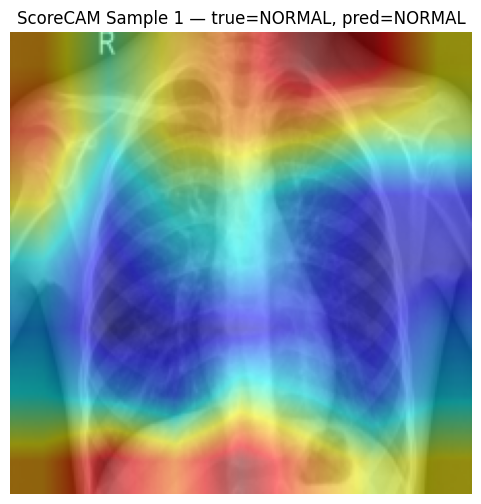

[ScoreCAM] saved figs/sample_1_scorecam.png


100%|██████████| 512/512 [00:07<00:00, 68.58it/s]


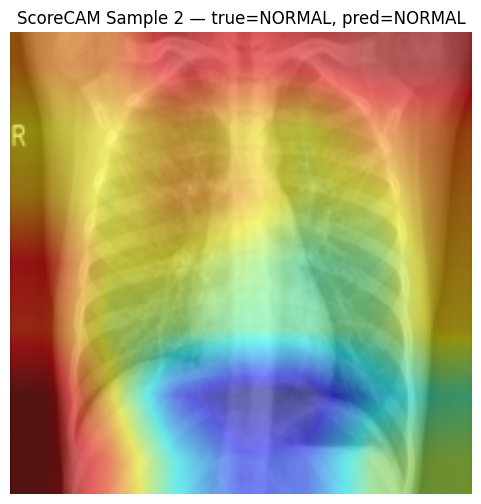

[ScoreCAM] saved figs/sample_2_scorecam.png


100%|██████████| 512/512 [00:08<00:00, 63.30it/s]


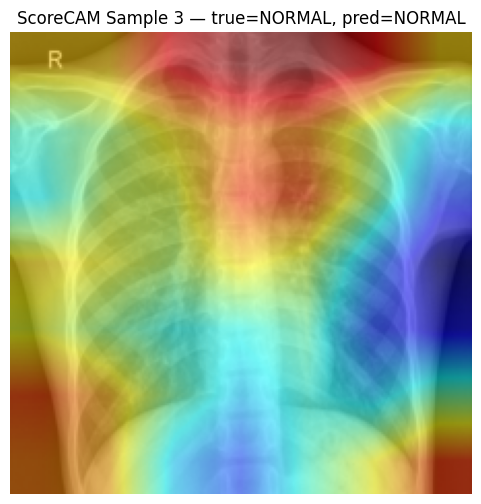

[ScoreCAM] saved figs/sample_3_scorecam.png


100%|██████████| 512/512 [00:08<00:00, 61.52it/s]


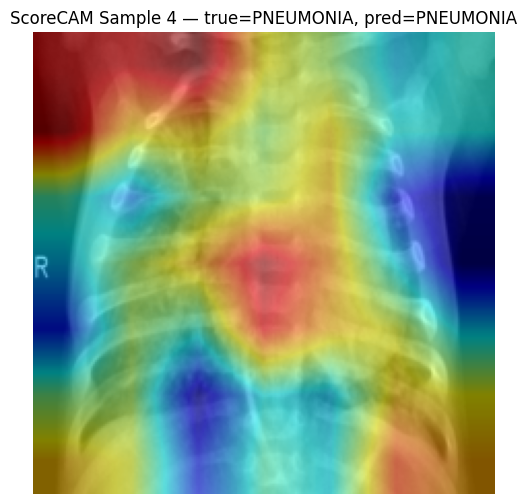

[ScoreCAM] saved figs/sample_4_scorecam.png


100%|██████████| 512/512 [00:07<00:00, 67.04it/s]


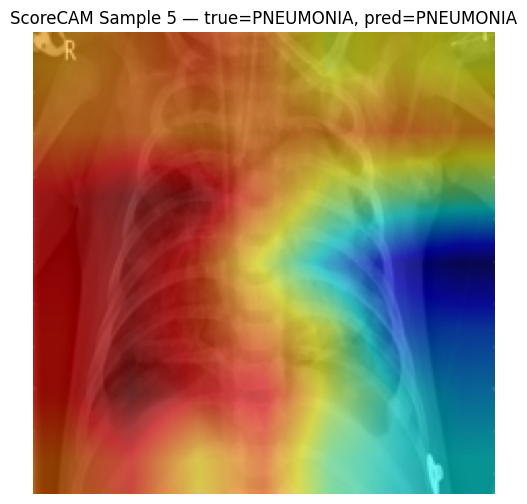

[ScoreCAM] saved figs/sample_5_scorecam.png


100%|██████████| 512/512 [00:07<00:00, 64.41it/s]


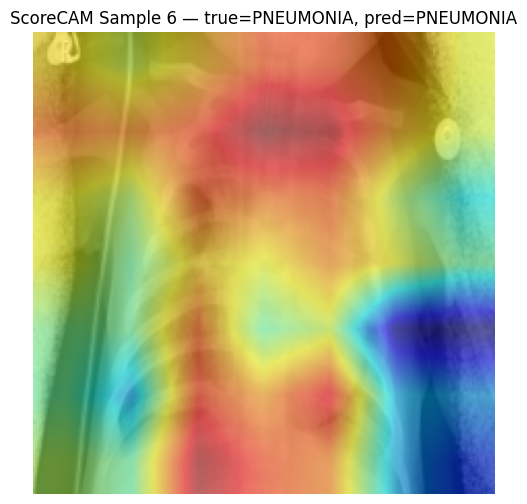

[ScoreCAM] saved figs/sample_6_scorecam.png


In [ ]:
# Run ScoreCAM
run_cam_method(ScoreCAM, "ScoreCAM", samples, target_layers, explain_predicted=True, scorecam_batch=4, save_prefix="sample")

# Reflection

**Comparing GradCAM Variants:**

Across the GradCAM, GradCAM++, and ScoreCAM visualizations, the highlighted regions were generally consistent—each method identified similar broad areas, with GradCAM showing the least precise, more diffuse activations, and GradCAM++/ScoreCAM producing relatively sharper/smoother maps.


**Visual cues / attention patterns:**
- For the three Normal samples (true=Normal, pred=Normal), the model consistently highlighted the outer periphery of the X-ray--particularly dark-red activations outside the body--while the central lung area remained largely blue (low activation). This suggests the model may be relying on contextual or background cues rather than true anatomical features of the lungs.
- For the Pneumonia samples (true=Pneumonia, pred=Pneumonia), the heatmaps shifted somewhat toward the center of the images, aligning better with where pulmonary irregularities would typically appear. However, even these maps often included bright regions outside the lungs (e.g., corners, edges, or image borders). These peripheral activations are unexpected and misleading, implying that the model may have learned correlations from background artifacts (such as image contrast, cropping, or scanner markings) rather than purely disease-related lung patterns.

**Importance of explainability in healthcare:**
In a medical-diagnostic setting like pneumonia detection, explainability is essential for trust and safety. Clinicians must understand why a model makes its decision before integrating it into patient care. Visual explanations help identify when the model bases predictions on irrelevant artifacts instead of actual lung pathology. Without these insights, a seemingly high-accuracy model could make dangerous mistakes if deployed on new data. Explainability allows developers to detect these issues, refine the dataset or model, and ultimately build systems that support, rather than mislead, physicians.

# AI Assistance Statement
Portions of this notebook were developed with assistance from OpenAI’s ChatGPT (GPT-5, October 2025). ChatGPT was used to help debug GradCAM implementation issues and generate helper functions for visualization (e.g., run_cam_method and preprocessing utilities). All generated code and explanations were reviewed, tested, and edited to ensure correctness and alignment with assignment requirements.

Specific dates/times and prompts to generate code blocks are listed below:

| Date            | Approx. Time | Purpose                  | Prompt Summary                                                                                                                                             |
| --------------- | ------------ | ------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Oct 4, 2025** | 2:00 PM      | Dataset setup            | “Help me write code to download and load the Kaggle Chest X-Ray Pneumonia dataset into PyTorch and display sample images.”                                 |
| **Oct 4, 2025** | 7:00 PM      | GradCAM debugging        | “GradCAM returned `NoneType` — can you help me debug and make it work properly with a pretrained ResNet-50 model?”                                         |
| **Oct 5, 2025** | 10:00 AM     | Explainability functions | “Simplify my notebook by writing reusable helper functions for GradCAM, GradCAM++, and ScoreCAM.”     |
| **Oct 5, 2025** | 4:00 PM      | Fine-tuning loop         | “Help me write a clean, optional fine-tuning loop for ResNet-50 controlled by a `DO_TRAIN` flag, with validation accuracy tracking and checkpoint saving.” |
| **Oct 5, 2025** | 6:00 PM      | Model loading            | “Write code that loads a local fine-tuned checkpoint if present, or defaults to pretrained weights if not found.”                                          |
| **Oct 5, 2025** | 9:00 PM      | Evaluation metrics       | “Provide code to evaluate the model's validation and test accuracy using PyTorch DataLoaders.”